In [1]:
import os
import torch
import torch.nn as nn
import torch.distributions as td
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import matplotlib.pyplot as plt
from tqdm.notebook import trange 
import random
from torch.utils.data import DataLoader, TensorDataset
# from models import RealNVP
# from models import AutoEncoderA, AutoEncoderC, AutoEncoderA2, AutoencoderA3, AutoEncoderB
from sklearn.model_selection import train_test_split
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import gc
import itertools
from ae_and_flow import AutoEncoder,NVP,net_s,net_t
from torch import distributions
from scipy import fftpack
import pickle


print("Available GPUs:", torch.cuda.device_count())
torch.cuda.set_device(0)
print("Current GPU:", torch.cuda.current_device())
device = torch.device("cuda")

data_dir = "/scratch/s/S.Liu/sbi_lab/data/"
figs_dir = "/scratch/s/S.Liu/sbi_lab/figs/grfs/" # Change this to your specification

for _path in [data_dir, figs_dir]:
    if not os.path.exists(_path):
        os.makedirs(_path, exist_ok=True)
        
z_dim=8
os.chdir('/home/s/S.Liu/grf_lab')

ModuleNotFoundError: No module named 'models'

In [45]:
"""
    Fit NVP flow to GRFs at the field level (likelihood).
"""

def convert(x):
    return torch.as_tensor(x).float()


def get_dataloader_from_arrays(data, targets, batch_size):

    class TensorDataset(Dataset):
        def __init__(self, data, targets):
            self.data = torch.as_tensor(data).float()
            self.labels = torch.as_tensor(targets).float()
        
        def __len__(self):
            return len(self.data)
        
        def __getitem__(self, idx):
            sample = self.data[idx]
            label = self.labels[idx]
            return sample, label

    # Create dataset and dataLoader
    dataset = TensorDataset(data, targets)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


def looploader(dataloader):
    while True:
        for x in iter(dataloader): 
            yield x

In [72]:
# Model / inference stuff
AB = np.array([1., 2.5]) # Fiducial cosmology
lower = np.array([0.1, 2.])
upper = np.array([2., 3.])
parameter_names = ["A", "B"]
# Data
n_pix = 32
data_shape = (n_pix, n_pix)
data_dim = np.prod(data_shape)
parameter_dim = len(AB)


# Load data 
D = np.load(os.path.join(data_dir, f"grfsL_{n_pix=}.npy"))
D_ = np.load(os.path.join(data_dir, f"dataL_{n_pix=}.npy"))
Y = np.load(os.path.join(data_dir, f"grfsL_parameters_{n_pix=}.npy"))
#load AE compressing latent vector
Z=np.load(os.path.join(data_dir, f"AEL_{z_dim}.npy"))
#load PCA compressing latent vector
pca_comp=np.load(os.path.join(data_dir, f"PCAL_{z_dim}.npy"))

#normalize
# Dc_mean=np.ones((D_comp.shape[0],1))@(D_comp[:4000].mean(axis=0)).reshape((1,-1))
# Dc_std=np.ones((D_comp.shape[0],1))@(D_comp[:4000].std(axis=0)).reshape((1,-1))
# D_comp=(D_comp-Dc_mean)/Dc_std
pca_mean=np.ones((pca_comp.shape[0],1))@(pca_comp[:5000].mean(axis=0)).reshape((1,-1))
pca_std=np.ones((pca_comp.shape[0],1))@(pca_comp[:5000].std(axis=0)).reshape((1,-1))
pca_comp=(pca_comp-pca_mean)/pca_std

# Add image channels for convolutions
n_use = 100000
D = convert(D[:n_use, None, ...])
D_ = convert(D_[None, None, ...]) # Single batch axis for single measurement
Y = convert(Y[:n_use])
Z=convert(Z)#pca_comp

D = 2. * (D - D.min()) / (D.max() - D.min()) - 1.

# Normalizing flow base distribution
prior = td.MultivariateNormal(
    loc=torch.zeros(z_dim).to(device), 
    covariance_matrix=torch.eye(z_dim).to(device)
)

# Mask arrays for normalizing flow
Dnum=[64,64,64]
L=len(Dnum)
dim = torch.arange(0, z_dim) % 2
masks = torch.stack(
    [
        dim if i % 2 else dim.flip(dims=(0,))
        for i in range(L)
    ]
)


Epoch 1, Train Loss: 10.3715, Validation Loss: 10.3537, LR: 1.000e-04
Epoch 2, Train Loss: 10.3282, Validation Loss: 10.3105, LR: 1.000e-04
Epoch 3, Train Loss: 10.2855, Validation Loss: 10.2676, LR: 1.000e-04
Epoch 4, Train Loss: 10.2417, Validation Loss: 10.2248, LR: 1.000e-04
Epoch 5, Train Loss: 10.1986, Validation Loss: 10.1823, LR: 1.000e-04
Epoch 6, Train Loss: 10.1562, Validation Loss: 10.1399, LR: 1.000e-04
Epoch 7, Train Loss: 10.1141, Validation Loss: 10.0977, LR: 1.000e-04
Epoch 8, Train Loss: 10.0718, Validation Loss: 10.0557, LR: 1.000e-04
Epoch 9, Train Loss: 10.0290, Validation Loss: 10.0138, LR: 1.000e-04
Epoch 10, Train Loss: 9.9873, Validation Loss: 9.9721, LR: 1.000e-04
Epoch 11, Train Loss: 9.9454, Validation Loss: 9.9305, LR: 1.000e-04
Epoch 12, Train Loss: 9.9029, Validation Loss: 9.8890, LR: 1.000e-04
Epoch 13, Train Loss: 9.8616, Validation Loss: 9.8476, LR: 1.000e-04
Epoch 14, Train Loss: 9.8184, Validation Loss: 9.8063, LR: 1.000e-04
Epoch 15, Train Loss: 9.7

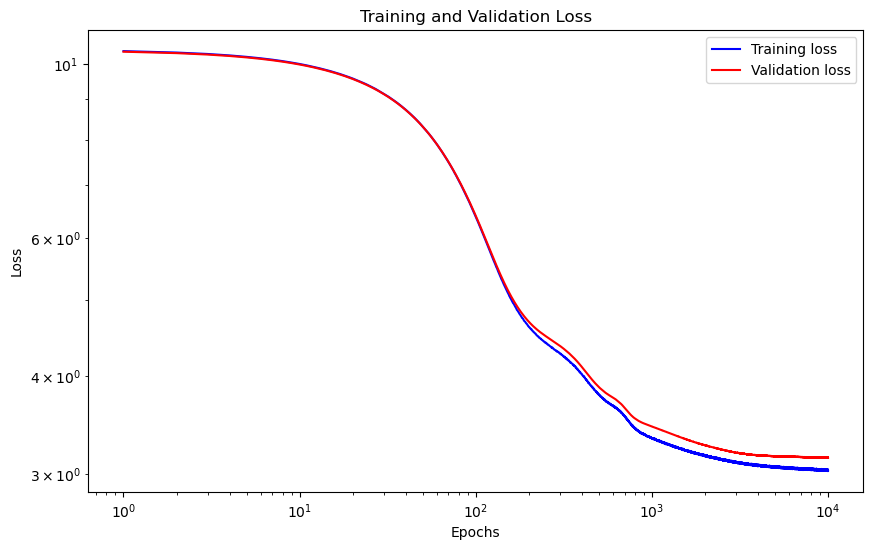

3.148954391479492


In [73]:
#hyperparameter scan, model saving and trainning result saving
acs=[nn.Tanh()]
Dnums=[[8,8,8]]
lrs=[1e-4]
count=0
for ac in acs:
    for Dnum in Dnums:
        for lr in lrs:
            seed=42
            lr=lr
            patience_lr=1000
            factor=0.3
            epochs=10000
            batch_size=1024
            patience=3000
            Dnum=Dnum
            activ_mid=ac
            activ_out='linear'
            tr_num=5000
            val_num=500

            # Mask arrays for normalizing flow
            L=len(Dnum)
            dim = torch.arange(0, z_dim) % 2
            masks = torch.stack(
                [
                    dim if i % 2 else dim.flip(dims=(0,))
                    for i in range(L)
                ]
            )

            hyperparameterss=[]
            best_results=[]
            tr_historys=[]
            val_historys=[]

            if seed!=None:
                np.random.seed(seed)
                random.seed(seed)
                torch.manual_seed(seed)
                torch.cuda.manual_seed(seed)
                torch.cuda.manual_seed_all(seed)

            train_dataset = TensorDataset(Z[:tr_num],Y[:tr_num])
            # val_dataset = TensorDataset(Z[:tr_num],Y[:tr_num])
            val_dataset = TensorDataset(Z[tr_num:tr_num+val_num],Y[tr_num:tr_num+val_num])
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            flow = NVP(inp_shape_s=z_dim+2,Dsize_s=Dnum,out_shape_s=z_dim,activ_mid_s=activ_mid,
                             inp_shape_t=z_dim+2,Dsize_t=Dnum,out_shape_t=z_dim,activ_mid_t=activ_mid,
                             net_s=net_s,net_t=net_t,masks=masks,prior=prior).to(device)

            best_model = copy.deepcopy(flow)
            optimizer = optim.Adam(flow.parameters(), lr=lr)

            if isinstance(patience_lr, list):
                scheduler=get_piecewise_scheduler(optimizer,patience_lr,factor)
            else:
                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=factor,patience=patience_lr)


            losses = []

            # Training loop with early stopping and learning rate scheduling
            best_loss = float('inf')
            best_tr_loss= float('inf')
            epochs_no_improve = 0

            global_train_loss = []
            global_val_loss = []

            #begin truaining
            for epoch in range(epochs):
                flow.train()
                train_loss = 0
                for xtrb, ytrb in train_loader:
                    xtrb = xtrb.to(device)
                    ytrb=ytrb.to(device)

                    optimizer.zero_grad()
                    loss=-flow.log_prob(xtrb,ytrb).mean()
                    loss.backward(retain_graph=True)
                    optimizer.step()
                    train_loss += loss.item()

                train_loss /= len(train_loader)
                global_train_loss.append(train_loss)

                flow.eval()
                val_loss = 0
                with torch.no_grad():
                    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                    for xvalb,yvalb in val_loader:
                        xvalb = xvalb.to(device)
                        yvalb = yvalb.to(device)
                        loss=-flow.log_prob(xvalb,yvalb).mean()
                        val_loss += loss.item()

                    val_loss /= len(val_loader)
                    if isinstance(patience_lr,list):
                        scheduler.step(epoch)
                    else:
                        scheduler.step(val_loss)
                        lr_ = optimizer.param_groups[0]['lr']
                        global_val_loss.append(val_loss)
                    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, LR: {lr_:.3e}")


                    # Early stopping and learning rate scheduling
                    if val_loss < best_loss:
                        best_loss = val_loss
                        best_model = flow
                    # evalu_tc(best_model,val_loader,m_mean.numpy().astype('float32'),1.,filename=None)
                        epochs_no_improve = 0
                    elif train_loss>best_tr_loss+0.15:
                        epochs_no_improve = 0
                    else:
                        epochs_no_improve += 1
                        best_tr_loss=train_loss
                    if epochs_no_improve >= patience and epoch>=35:
                        print("Early stopping triggered")
                        break
            tr_losses,val_losses=global_train_loss,global_val_loss

            #compute the index coresponding to the best validation loss and validation metric
            min_index=val_losses.index(min(val_losses))

            best_result=[tr_losses[min_index],val_losses[min_index],sum(p.numel() for p in best_model.parameters())]
            param_names = ['Dnum','lr','ac']

            hyperparameters=[Dnum,lr,activ_mid]
            hyperparameters = dict(zip(param_names, hyperparameters))
            print('hypeparameters: ', hyperparameters)
            print('best results:',best_result)
            hyperparameterss.append(hyperparameters)
            best_results.append(best_result)
            tr_historys.append(tr_losses)
            val_historys.append(val_losses)

            total_epoch = range(1, len(tr_losses) + 1)
            plt.figure(figsize=(10, 6))
            plt.loglog(total_epoch , tr_losses, 'b', label='Training loss')
            plt.loglog(total_epoch , val_losses, 'r', label='Validation loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            # plt.ylim([-2.,+1.])
            # plt.savefig(os.path.join(figs_dir, "loss_ae.png"))
            plt.legend()
            plt.show()
            torch.save(best_model,os.path.join(data_dir, f"flow_AE.pth"))
            flow=torch.load(os.path.join(data_dir, f"flow_AE.pth"))
            flow.eval()
            val_loss = 0.
            with torch.no_grad():
                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                for xvalb,yvalb in val_loader:
                    xvalb = xvalb.to(device)
                    yvalb = yvalb.to(device)
                    loss=-flow.log_prob(xvalb,yvalb).mean()
                    val_loss += loss.item()
                val_loss /= len(val_loader)
            print(val_loss)

            
            
            gc.collect()
            torch.cuda.empty_cache()


In [10]:
#collect and merge the training result
counts=range(0,18)
h,b,t,v=[],[],[],[]
for count in counts:
    with open(f'FlowAES_hyper_{count}.pickle','rb') as f:
        h.extend(copy.deepcopy(pickle.load(f)))
    with open(f'FlowAES_best_{count}.pickle','rb') as f:
        b.extend(copy.deepcopy(pickle.load(f)))
    with open(f'FlowAES_tr_{count}.pickle','rb') as f:
        t.extend(copy.deepcopy(pickle.load(f)))
    with open(f'FlowAES_val_{count}.pickle','rb') as f:
        v.extend(copy.deepcopy(pickle.load(f)))
with open(f'FlowAES_hyper.pickle','wb') as f:
    pickle.dump(h,f)
with open(f'FlowAES_best.pickle','wb') as f:
    pickle.dump(b,f)
with open(f'FlowAES_tr.pickle','wb') as f:
    pickle.dump(t,f)
with open(f'FlowAES_val.pickle','wb') as f:
    pickle.dump(v,f)


In [40]:
h,b,t,v=[],[],[],[]
with open(f'FlowPCA_hyper.pickle','rb') as f:
    h.extend(copy.deepcopy(pickle.load(f)))
with open(f'FlowPCA_best.pickle','rb') as f:
    b.extend(copy.deepcopy(pickle.load(f)))

In [37]:
#find the optimal hyperparameter setting and results
b2=np.array(b).T[1]
indices=np.argsort(b2)
btop20=np.array(b)[indices]
htop20=[h[i] for i in indices]
htop20,btop20

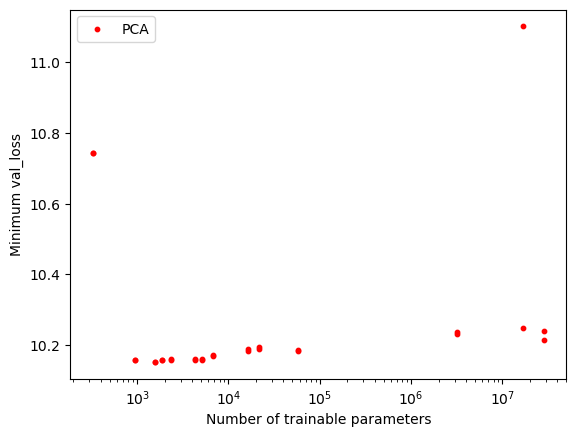

In [41]:
#plot the loss-size relation
os.chdir('/home/s/S.Liu/grf_lab')
b1=np.array(b)
plt.scatter(b1[:,2],b1[:,1],c='r',s=10,label='PCA')
plt.xlabel('Number of trainable parameters')
plt.ylabel('Minimum val_loss')
plt.xscale('log')
plt.legend()
plt.savefig(f'lab-report/data_and_images/flowPCAscan_Minimum_val_loss_Number_of_trainable_parameters.png')

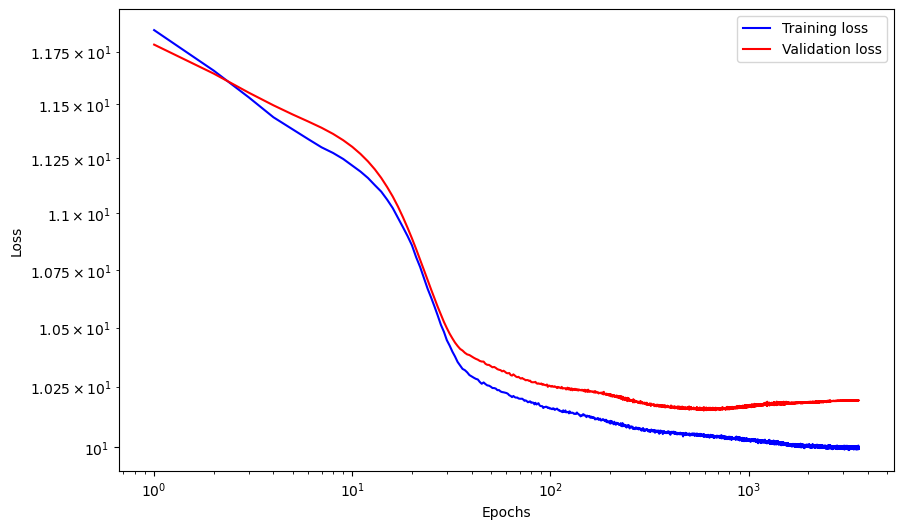

In [25]:
#plot the learning cureve
tr_losses,val_losses=t[indices[0]],v[indices[0]]
total_epoch = range(1, len(tr_losses) + 1)
plt.figure(figsize=(10, 6))
plt.loglog(total_epoch , tr_losses, 'b', label='Training loss')
plt.loglog(total_epoch , val_losses, 'r', label='Validation loss')
# plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.ylim([-2.,+1.])
plt.legend()
plt.savefig(f'lab-report/data_and_images/flowPCA_loss_ae.png')
plt.show()

In [63]:
def _get_k(input_array, box_dims):
    '''
        Get the k values for input array with given dimensions.
        Return k components and magnitudes.
        For internal use.
    '''
    # Assuming 2d
    x, y = np.indices(input_array.shape, dtype='int64')
    # Centred k-space frequencies (k=0 is at the centre of the map)
    center = np.array([(x.max() - x.min()) / 2, (y.max() - y.min()) / 2]).astype('float64')
    # Scale by box length
    kx = (2. * np.pi * (x - center[0]) / box_dims[0]).astype('float64')
    ky = (2. * np.pi * (y - center[1]) / box_dims[1]).astype('float64')
    # Magnitudes of k vectors
    k = np.sqrt(kx ** 2 + ky ** 2)
    return [kx, ky], k


def _get_kbins(kbins, box_dims, k):
    '''
        Make a list of bin edges if kbins is an integer,
        otherwise return it as it is.
    '''
    kmin = 2. * np.pi / max(box_dims) # Minimum freq is that which fits in the box, scale of box
    kbins = np.linspace(kmin, k.max(), kbins + 1)
    return kbins


def power_spectrum_nd(input_array, box_dims=None):
    ''' 
        Calculate the power spectrum of input_array and return it as an n-dimensional array,
        where n is the number of dimensions in input_array
        box_side is the size of the box in comoving Mpc. If this is set to None (default),
        the internal box size is used
        
        Parameters:
            * input_array (numpy array): the array to calculate the 
                power spectrum of. Can be of any dimensions.
            * box_dims = None (float or array-like): the dimensions of the 
                box. If this is None, the current box volume is used along all
                dimensions. If it is a float, this is taken as the box length
                along all dimensions. If it is an array-like, the elements are
                taken as the box length along each axis.
        
        Returns:
            The power spectrum in the same dimensions as the input array.		
    '''
    box_dims = [box_dims[0]] * len(input_array.shape)

    # Transform to Fourier space
    ft = fftpack.fftshift(fftpack.fftn(input_array.astype('float64')))

    # Calculate power
    power_spectrum = np.abs(ft) ** 2.

	# Scale by box volume
    boxvol = np.prod(box_dims)
    pixelsize = boxvol / np.prod(input_array.shape)
    power_spectrum *= pixelsize ** 2. / boxvol
	
    return power_spectrum


def make_gaussian_random_field(n_pix, box_dim, power_spectrum, random_seed=None):
    '''
        Generate a Gaussian random field with the specified
        power spectrum.
        
        Parameters:
            * dims (tuple): the dimensions of the field in number
                of cells. Can be 2D or 3D.
            * box_dims (float or tuple): the dimensions of the field
                in cMpc.
            * power_spectrum (callable, one parameter): the desired 
                spherically-averaged power spectrum of the output.
                Given as a function of k
            * random_seed (int): the seed for the random number generation
                
        Returns:
            The Gaussian random field as a numpy array
    '''
    dims = (n_pix, n_pix)
    box_dims = [box_dim] * len(dims)
    assert len(dims) == 2 

    if random_seed != None:
        np.random.seed(random_seed)
    
    # Generate map in Fourier space, Gaussian distributed real and imaginary parts 
    # (= uniform amplitude, Gaussian phases). This field has P(k) = 1 for all k.
    map_ft_real = np.random.normal(loc=0., scale=1., size=dims)
    map_ft_imag = np.random.normal(loc=0., scale=1., size=dims)
    map_ft = map_ft_real + 1j * map_ft_imag

    # Get k modes for power spectrum, radially symmetric for homog. + iso. field.
    kx_ky, k = _get_k(map_ft_real, box_dims) # Get k values given dimensions of field

    # Numerical stability
    # k[np.abs(k) < 1.e-6] = 1.e-6
    
    # Scale factor
    boxvol = np.prod(box_dims) # = L^n_dims
    pixelsize = boxvol / (np.prod(map_ft_real.shape))
    scale_factor = pixelsize ** 2 / boxvol
    
    # Scale Fourier map by power spectrum (e.g. scale by covariance: same as reparameterization trick d_k = mu_k + noise * cov_k)
    map_ft *= np.sqrt(power_spectrum(k) / scale_factor) # Covariance scales with volume dictated by scale factor?
    
    # Inverse FT the Fourier space realisation that has been scaled by power-spectrum covariance
    map_ift = fftpack.ifftn(fftpack.fftshift(map_ft))
    
    # Real part of field
    map_real = np.real(map_ift)
    return map_real

In [74]:

# Load grf
D = np.load(os.path.join(data_dir, f"grfsL_{n_pix=}.npy"))

grf=D[tr_num+val_num:tr_num+val_num+500]

D = 2. * (D - D.min()) / (D.max() - D.min()) - 1.
D = convert(D[:n_use, None, ...])


In [80]:
#prepare the data for analysing the trained flow
lower = np.array([0.1, 2.])
upper = np.array([2., 3.])
box_dims=[1.,1.]
autoencoder=torch.load(os.path.join(data_dir, f"ae5000_{z_dim}.pth")).to(device)
flow=torch.load(os.path.join(data_dir, f"flow_AE.pth")).to(device)
flow.eval()

# test_dataset = TensorDataset(D[:tr_num],D[:tr_num])
test_dataset = TensorDataset(D[tr_num+val_num:tr_num+val_num+500],D[tr_num+val_num:tr_num+val_num+500])
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

autoencoder.eval()

Z=Z[tr_num+val_num:tr_num+val_num+500]
p=Y[tr_num+val_num:tr_num+val_num+500]#Y[:tr_num]#
prior_log_prob = np.log(1. / np.prod(upper - lower))

In [76]:
def eavluate(x,p,Z,flow,prior_log_prob,box_dims,figs_dir,lower,upper,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    
    p=p.cpu().detach().numpy()
    flow=flow.to(device)
    _A, _B = np.mgrid[lower[0]:upper[0]:100j, lower[1]:upper[1]:100j]
    AB = torch.as_tensor(np.vstack([_A.ravel(), _B.ravel()])).float().T.to(device)
    _AB=AB.cpu().detach().numpy()
    kx_ky, k=_get_k(x[0], box_dims)
    
    Pk=np.zeros((len(AB),x.shape[1],x.shape[2])).astype('float64')
    for j in range(len(Pk)):
        A,B=_AB[j][0].astype('float64'),_AB[j][1].astype('float64')
        pk_fn = lambda k: A * k ** -B  
        Pk[j]=pk_fn(k)
    FAA=np.zeros((len(p),))
    FBB=np.zeros((len(p),))
    for i in range(len(p)):
        A,B=p[i][0].item(),p[i][1].item()
        pk_fn = lambda k: A * k ** -B 
        pk_fnA = lambda k: k ** -B 
        pk_fnB = lambda k: -A * k ** -B *np.log(k)
        FAA[i]=1./2.*((pk_fn(k)**(-2))*pk_fnA(k)*pk_fnA(k)).sum()
        FBB[i]=1./2.*((pk_fn(k)**(-2))*pk_fnB(k)*pk_fnB(k)).sum()
                           
    devi_list=[]
    
    for i in range(len(x)):
        x_k=power_spectrum_nd(x[i],box_dims)
        log_post_anal=np.zeros((len(AB),))
    
        for j in range(len(Pk)):
            log_post_anal[j]=(-(x_k)/(2.*Pk[j])-0.5*np.log(Pk[j])).sum()#-(x_k)/(2.*Pk[j])-
            # print((-0.5*np.log(Pk[j])).sum())
        # if i>=1:
        #     print((np.abs(x[i]-x[i-1])/x[i]).mean(),(np.abs(x_k1-x_k)/x_k).mean(),(np.abs(log_post_anal1-log_post_anal)).mean(),np.abs(log_post_anal1-log_post_anal),log_post_anal,log_post_anal)
        _Z=torch.tile(Z[i], (len(AB),1))
        inference_dataset=TensorDataset(_Z,AB)
        inference_dataloader = DataLoader(
        inference_dataset,batch_size=2000,shuffle=False)
        log_post_pred = []
        for z, ab in inference_dataloader:
            z= z.to(device)
            ab=ab.to(device)
            log_post_pred.append(flow.log_prob(z, ab)+ prior_log_prob)
        log_post_pred=torch.cat(log_post_pred).cpu().detach().numpy()
        log_post_pred=log_post_pred.reshape(-1,)
        # devi=(np.exp(log_post_anal)-np.exp(log_post_pred)*(np.exp(log_post_anal).sum()/np.exp(log_post_pred).sum()))**2
        # prob_devi=(devi*np.exp(log_post_anal)).mean()/(np.exp(log_post_anal)**3).mean()
        p_devi=np.abs(_AB[np.argmax(log_post_pred)]-p[i])
        print(p_devi)
        stdA=np.sqrt(FAA[i]**(-1))
        stdB=np.sqrt(FBB[i]**(-1))
        pr_devi=(p_devi/np.array([stdA,stdB])).sum()
        p_devi=np.sqrt((p_devi**2).sum())
        print(p[i][0],p[i][1],p_devi,pr_devi,stdA,stdB)                           
        devi_list.append([p[i][0],p[i][1],p_devi,pr_devi,stdA,stdB])
        
        plt.figure(dpi=200, figsize=(5., 5.))
        plt.scatter(*_AB.T, c=log_post_pred+(log_post_anal-log_post_pred).mean(),label='predicted posterior')#+np.log(np.exp(log_post_anal).sum()/np.exp(log_post_pred).sum()
        if i%50==0:
            plt.savefig(figs_dir+"pred_{}.png".format(i))
        plt.show()
        plt.close()     
        plt.figure(dpi=200, figsize=(5., 5.))
        plt.scatter(*_AB.T, c=log_post_anal,label='true posterior')
        if i%50==0:
            plt.savefig(figs_dir+"true_{}.png".format(i))
        plt.show()
        plt.close()    
        log_post_anal1=log_post_anal
    return devi_list       


In [ ]:
#evaluate the model
devi=eavluate(grf,p,Z[:tr_num],flow,prior_log_prob,box_dims,'/home/s/S.Liu/grf_lab/lab-report/data_and_images/AE_',lower,upper,device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

In [78]:
#save m and t
with open(f'/home/s/S.Liu/grf_lab/lab-report/data_and_images/AE_devi.pickle','wb') as f:
    pickle.dump(devi,f)

In [101]:
#calculate m and t
with open(f'/home/s/S.Liu/grf_lab/lab-report/data_and_images/PCA_over_devi.pickle','rb') as f:
    devi=copy.deepcopy(pickle.load(f))
devi=np.array(devi)
m=devi[:,2]
t=devi[:,3]
AA=devi[:,4]
BB=devi[:,5]
t.mean(),t.std(),m.mean(),m.std(),(np.sqrt(((lower[0]-upper[0])**2+(lower[1]-upper[1])**2)/6)-m.mean())/m.std()

(0.784956822382196,
 0.7520729921536613,
 0.008681734127458185,
 0.006238050792459504,
 139.12431103349172)

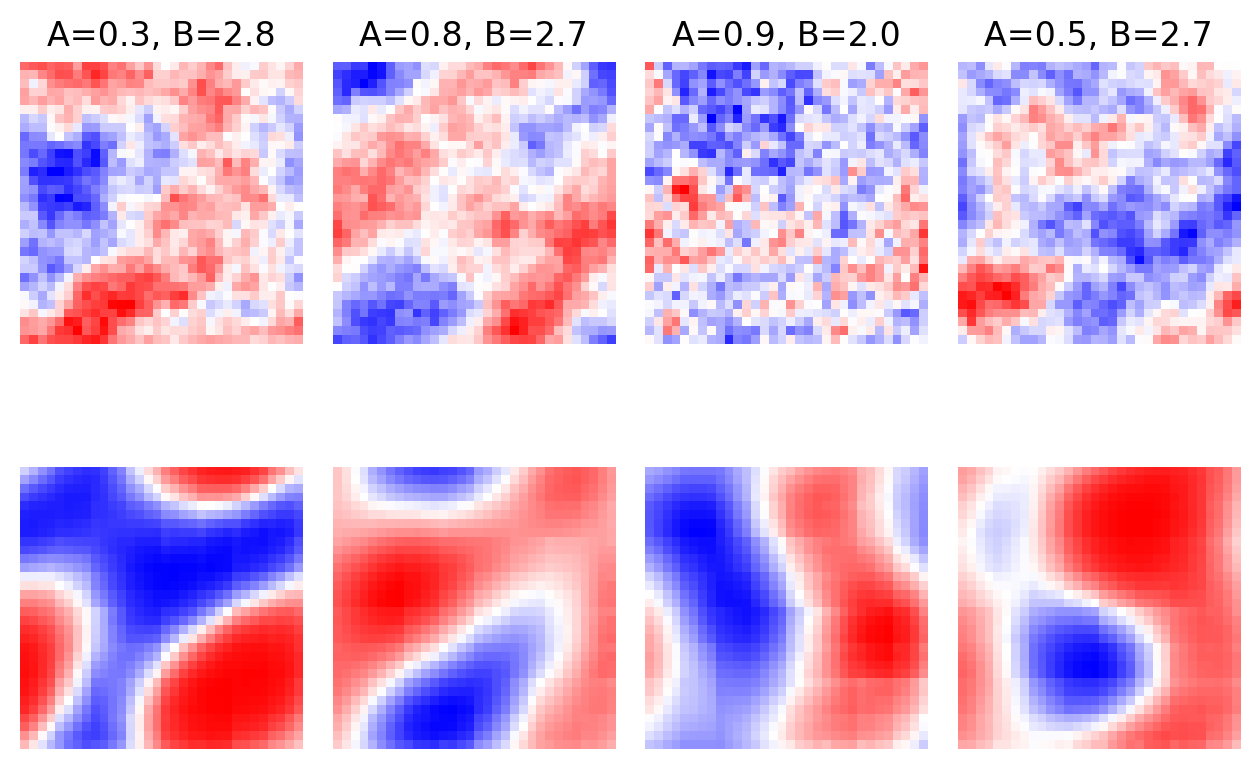

In [81]:
#sample from the flow
fig, axs = plt.subplots(2, 4, dpi=200)
for i, ax in enumerate(axs[0, :]):
    A, B = p[i]
    ax.set_title(f"{A=:.1f}, {B=:.1f}")
    im = ax.imshow(grf[i].reshape(data_shape), cmap="bwr")
    ax.axis("off")
for i, ax in enumerate(axs[1, :]):
    im = ax.imshow(autoencoder.decoder(flow.sample(1, p[i][None,...].to(device))).cpu().detach().numpy().reshape(data_shape), cmap="bwr")
    ax.axis("off")
plt.tight_layout()
plt.savefig('/home/s/S.Liu/grf_lab/lab-report/data_and_images/flowAE_samples.png')
plt.show()
plt.close()
